### HomeWork 8
#### Mouselinos Spyridon
#### February 2020
***

### Exersize 2
***

In [1]:
### Imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### Let's define the sigmoid function  with scale a
def sigmoid(t,a):
    return 1/(1+ np.exp(-a*t))


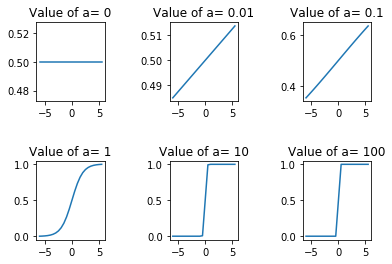

In [3]:
### a) Plot the function for different parameters of a
datapoints = np.arange(-6.0,6.0,0.5)

a_values =[0, 0.01, 0.1, 1, 10, 100]
subplot_values = [231,232,233,234,235,236]

fig = plt.figure()
for i in range(6):
    plt.subplot(subplot_values[i])
    plt.plot(datapoints, sigmoid(datapoints,a_values[i]))
    plt.title('Value of a= {}'.format(a_values[i]))
plt.subplots_adjust(hspace=0.75, wspace=0.95)
plt.show()


It is shown that as a increases the sigmoid function approaches the unit step function.
Also as a goes to 0, the sigmoid becomes constant approaching the value of 0.5. 

### Exersize 4
***

In [99]:
import scipy.io as sio
import numpy as np
import numpy.matlib as nm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm 

Dataset = sio.loadmat('HW8.mat')
train_x = Dataset['train_x']
train_y= Dataset['train_y']

test_x = Dataset['test_x']
test_y = Dataset['test_y']

In [100]:
### First let's separate the class 1 and class 2 points
class_1_points = train_x[np.where(train_y==1),:][0]
class_2_points = train_x[np.where(train_y==2),:][0]

####  a) Bayes classiﬁer 
***

In [101]:
### Count and get statistics for each class
N1 = class_1_points.shape[0]
N2 = class_2_points.shape[0]
N = len(train_y) 

N1_mean = np.mean(class_1_points,axis=0)
N2_mean = np.mean(class_2_points,axis=0)

N1_cov = 1/ N1*((class_1_points - nm.repmat(N1_mean,N1,1) ).T ).dot((class_1_points - nm.repmat(N1_mean,N1,1)))
N2_cov =  1/ N2*((class_2_points - nm.repmat(N2_mean,N2,1)).T).dot((class_2_points - nm.repmat(N2_mean,N2,1)))

In [102]:
P1 = N1/N 
P2 = N2/N

In [103]:
N_test = len(test_y) 

In [104]:
class1 = multivariate_normal(N1_mean,N1_cov)
class1_scores = class1.pdf(test_x)*P1 

In [105]:
class2 = multivariate_normal(N2_mean,N2_cov) 
class2_scores = class2.pdf(test_x)*P2

In [106]:
Bayes_test_y = np.zeros((N,1))
Bayes_test_y[class1_scores > class2_scores] = 1 
Bayes_test_y[class2_scores > class1_scores] = 2

In [36]:
error_bayes = np.sum(np.fromiter((i==1 for i in Bayes_test_y != test_y),np.float)) /N_test 

In [37]:
print(error_bayes)

0.15


#### b) Naive Bayes CLassifier
***

In [24]:
### Here we need to recalculate the S matrices assuming independence
Cov_11 = np.sum(np.power(class_1_points[:,0].reshape(N1,1) - np.matlib.repmat(N1_mean[0],N1,1),2)) / N1
Cov_12 = np.sum(np.power(class_1_points[:,1].reshape(N1,1) - np.matlib.repmat(N1_mean[1],N1,1),2)) / N1
Cov_21 = np.sum(np.power(class_2_points[:,0].reshape(N1,1) - np.matlib.repmat(N2_mean[0],N2,1),2)) / N2
Cov_22 = np.sum(np.power(class_2_points[:,1].reshape(N1,1) - np.matlib.repmat(N2_mean[1],N2,1),2)) / N2

In [25]:
class1_scores = np.multiply(norm(N1_mean[0],np.sqrt(Cov_11)).pdf(test_x[:,0]), norm(N1_mean[1],np.sqrt(Cov_12)).pdf(test_x[:,1]))
class2_scores = np.multiply(norm(N2_mean[0],np.sqrt(Cov_21)).pdf(test_x[:,0]), norm(N2_mean[1],np.sqrt(Cov_22)).pdf(test_x[:,1]))

In [26]:
Naive_Bayes_test_y = np.zeros((N,1))
Naive_Bayes_test_y[class1_scores > class2_scores] = 1 
Naive_Bayes_test_y[class2_scores > class1_scores] = 2

In [38]:
error_naive_bayes = np.sum(np.fromiter((i==1 for i in Naive_Bayes_test_y!=test_y),np.float)) /N_test 

In [39]:
print(error_naive_bayes)

0.165


#### c) knn classiﬁer
***

In [40]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(train_x, train_y.ravel())
kNN_test_y = clf.predict(test_x).reshape(N_test,1)
error_kNN = np.sum(np.fromiter((i==1 for i in kNN_test_y!=test_y),np.float)) /N_test 

In [42]:
print(error_kNN)

0.17


#### d) logistic regression classifier
***

In [155]:
class LogisticRegressionClassifier:
    def __init__(self, lr=0.01, tolerance=0.0001, maxIterations=500, extend_with_ones=True):
        self.lr = lr
        self.tolerance = tolerance
        self.maxIterations = maxIterations
        self.extend_with_ones = extend_with_ones
        self.final_theta = None
        self._isfit = False

    def sigmoid(self,t):
        return 1/(1+np.exp(-t))


    def fit(self, X, y):
        ### Rectify y to 0-1
        y = y-1
        ### Find the Input shape
        input_length = X.shape[0]
        input_shape = X.shape[1]
        ### If bias is required extend the input with ones
        if self.extend_with_ones:
            X = np.hstack((np.ones((input_length,1)),X))
            input_shape += 1
        ### Initialize the theta parameter table
        theta =  np.random.normal(0,1,size=(input_shape,1))
        ### If there is not significant update of theta stop
        ### The magnitude of the gradient update can be calculated
        ### By the L1 norm of the gradient at each step
        gradient_magnitude = 10000
        step = 0

        while step < self.maxIterations:
            step += 1
            ### We can use the sigmoid we created at Exersize 2 with alpha 1
            s = self.sigmoid((theta.T).dot(X.T))
            gradient = (X.T).dot((s.T - y))
            gradient_magnitude = np.linalg.norm(gradient)
            if gradient_magnitude < self.tolerance:
                self.final_theta = theta
                break
            old_theta = theta
            theta = old_theta - self.lr * gradient
        return

    
    def transform(self, X, y_test, threshold=0.5):
        ### Rectify y 
        y_test = y_test-1
        
        ### Find the Input shape
        input_shape = X.shape[0]
        ### If bias is required extend the input with ones
        if self.extend_with_ones:
            X = np.hstack((np.ones((input_shape,1)),X))
            input_shape += 1

        predictions = (self.sigmoid((self.final_theta.T).dot(X.T))).T
        class_predictions = np.zeros_like(predictions)
        class_predictions[np.where(predictions>0.5)] = 1

        error_Logistic_Regression = np.sum(np.fromiter((i==1 for i in class_predictions!=y_test),np.float)) / len(y_test) 
        return error_Logistic_Regression, class_predictions+1

In [156]:
clf = LogisticRegressionClassifier(lr=0.01, tolerance=0.0001, maxIterations=500)
clf.fit(X=train_x,y=train_y)

In [159]:
error = clf.transform(X=test_x,y_test=test_y)[0]
lry = clf.transform(X=test_x,y_test=test_y)[1]
print("Error of Logistic Regression",error)

Error of Logistic Regression 0.155


#### e) Classiﬁcation results on the test set
***


In [184]:
### Let's Plot the Training Set and the Test set
def plot_dataset(name, points, labels):
    plt.figure(figsize=(10,10))
    plt.title(name)
    class_1 = points[np.where(labels==1),:][0]
    class_2 = points[np.where(labels==2),:][0]
    plt.scatter(x=class_1[:,0], y=class_1[:,1], c='m', label='class 1')
    plt.scatter(x=class_2[:,0], y=class_2[:,1], c='y', label='class 2')
    plt.xlabel("1st Dimention of the Dataset")
    plt.ylabel("2nd Dimention of the Dataset")
    plt.legend(loc=1) 
    plt.show()
    plt.close()
    return

def plot_predictions(name, points, real_labels, predicted_labels):
    plt.figure(figsize=(10,10))
    plt.title(name)
    class_1 = points[np.where(real_labels==1),:][0]
    class_2 = points[np.where(real_labels==2),:][0]
    class_1_correct = points[np.where(predicted_labels==1),:][0]
    class_2_correct = points[np.where(predicted_labels==2),:][0]
    plt.scatter(x=class_1[:,0], y=class_1[:,1], c='b',marker='o',label='Real class 1')
    plt.scatter(x=class_1_correct[:,0], y=class_1_correct[:,1], c='b', marker='+',label='Predicted class 1')
    plt.scatter(x=class_2[:,0], y=class_2[:,1], c='y', marker='o',label='Real class 2')
    plt.scatter(x=class_2_correct[:,0], y=class_2_correct[:,1], c='y', marker='+',label='Predicted class 2')
    plt.xlabel("1st Dimention of the Dataset")
    plt.ylabel("2nd Dimention of the Dataset")
    plt.legend(loc=1) 
    plt.show()
    plt.close()
    return

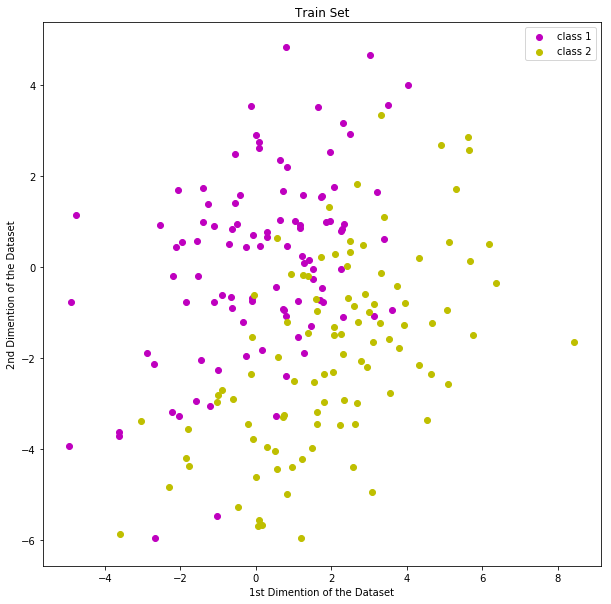

In [185]:
### Let's show the Train Set Points
plot_dataset(name='Train Set',points=train_x,labels=train_y)

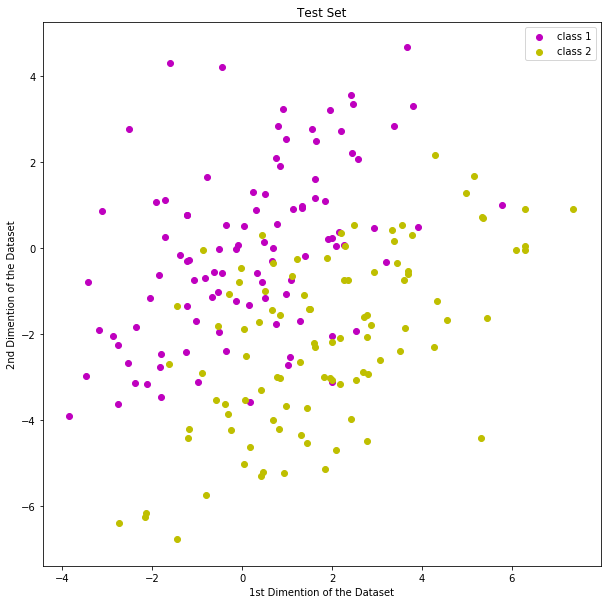

In [186]:
### Let's show the Test Set Points
plot_dataset(name='Test Set',points=test_x,labels=test_y)

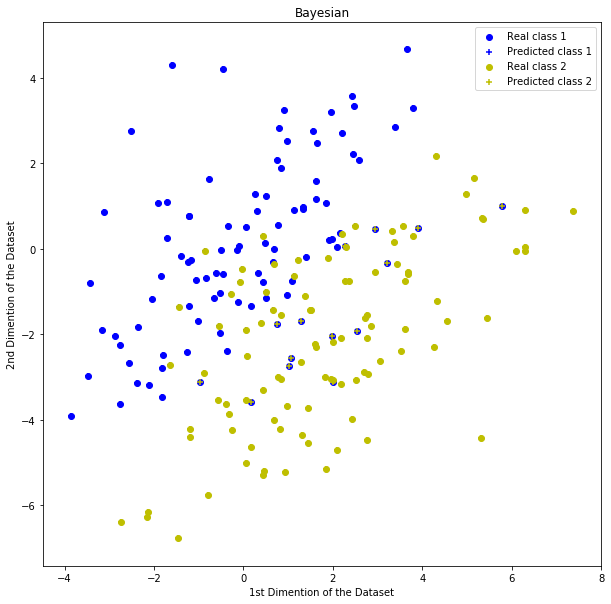

In [187]:
### Now let's plot for each classifier the predictions on the test set
plot_predictions(name='Bayesian', points=test_x, real_labels=test_y, predicted_labels=Bayes_test_y)

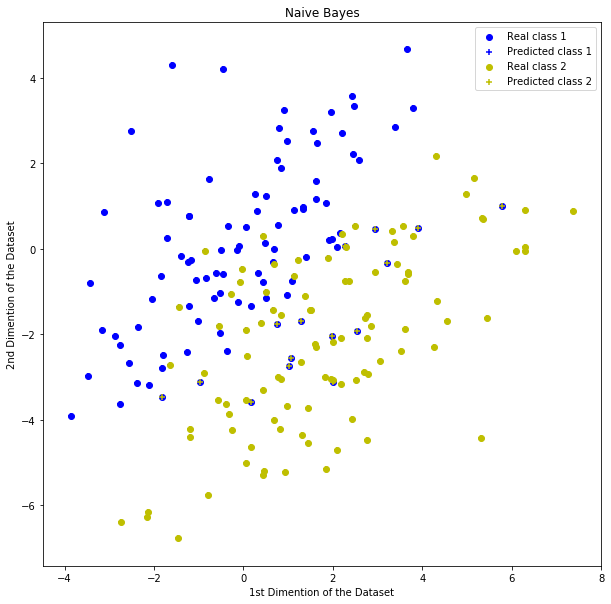

In [188]:
plot_predictions(name='Naive Bayes',points=test_x, real_labels=test_y, predicted_labels=Naive_Bayes_test_y)

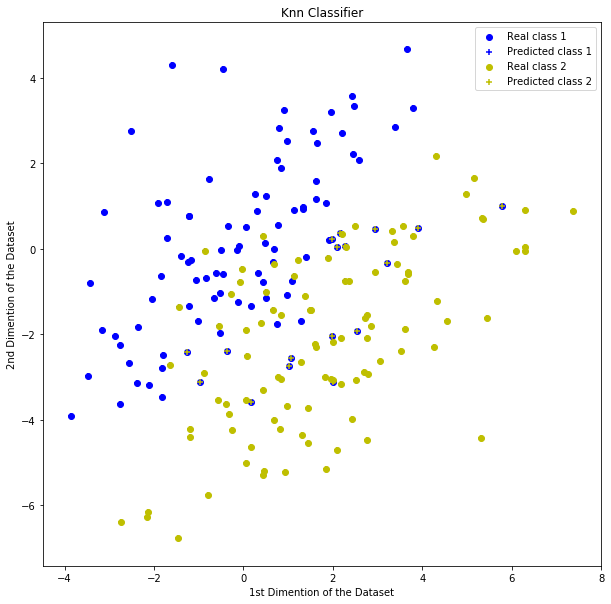

In [189]:
plot_predictions(name='Knn Classifier',points=test_x,real_labels=test_y, predicted_labels=kNN_test_y)

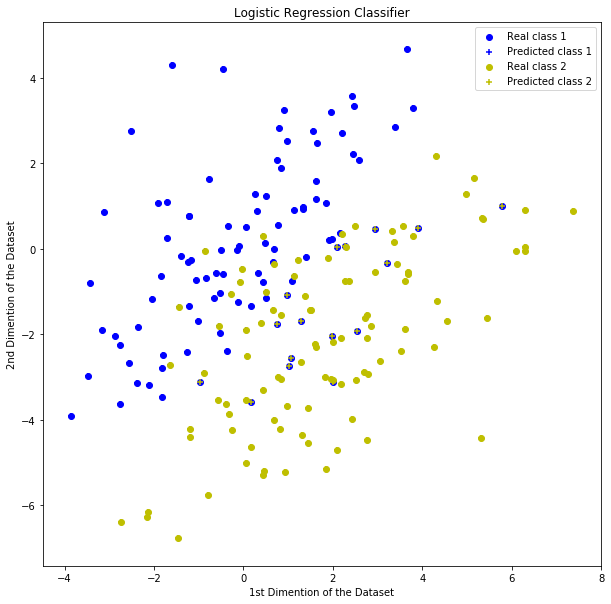

In [190]:
plot_predictions(name='Logistic Regression Classifier',points=test_x,real_labels=test_y, predicted_labels=lry)

From the results it is shown that the Bayes classiﬁer outperforms the other 3 classiﬁers.
This is expected due to the fact that the Bayes classiﬁer is better that the Naive Bayes since the two classes have non-diagonal covariance matrices.
The same applies for the knn Classifier that we know from theory that has worse performance at small k and approaches the Bayes Classifier at high k.

The Bayes classiﬁer would exhibit the same performance with Naive Bayes if the covariance matrices of normal distribution that generated the samples of the two classes was diagonal.


It should be also noted that the results obtained by Logistic regression on the test set are quite close to the ones obtained by the Bayes classiﬁer who is optimal.The assumption here is of linear separability of the 2 classes that is strongly indicated visually.